## 1. Replicate the generation of random functions frm Figure 2.2

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
PI = math.pi

In [2]:
def covariance_function(x1,x2):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] = math.exp(-1/2*(abs(xp-xq)**2))
    return out

In [3]:
x = np.linspace(-5,5,50)
prior_mean = np.zeros(50)
prior_cov = covariance_function(x,x)

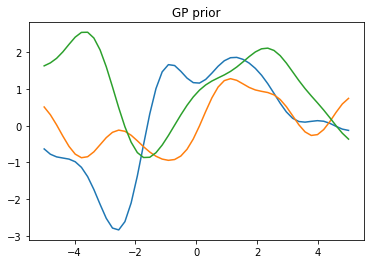

In [4]:
plt.figure()
plt.title("GP prior")
for i in range(3):
    prior = np.random.multivariate_normal(prior_mean,prior_cov)
    plt.plot(x,prior)
plt.show()

### Noise Free

In [5]:
# Data
x_data = np.array([[-4,-3.0,-1.0,0.0,1.0]]).T
y_data = np.array([[-2.0,0,1.0,2.0,-1.0]]).T
x = np.linspace(-5,5,50).reshape(-1,1)

In [6]:
post_mean = np.matmul(np.matmul(covariance_function(x,x_data),
                                np.linalg.inv(covariance_function(x_data,x_data))),y_data)
post_cov = covariance_function(x,x) - np.matmul(np.matmul(covariance_function(x,x_data),
                                np.linalg.inv(covariance_function(x_data,x_data))),covariance_function(x_data,x))

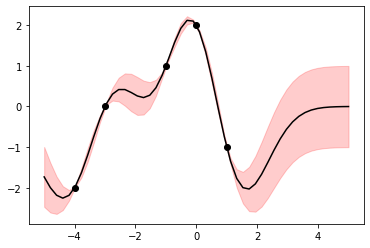

In [7]:
a = post_cov.diagonal().reshape(-1,1)
a = np.sqrt(a)
plt.figure()
plt.plot(x_data,y_data,'o',color='k')
plt.plot(x.reshape(-1),post_mean,color='k')
plt.fill_between(x.reshape(-1), (post_mean-a).reshape(-1),(post_mean+a).reshape(-1),alpha=0.2,color='r')
plt.show()

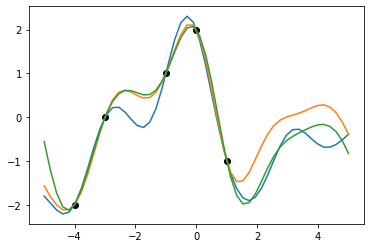

In [8]:
plt.plot(x_data,y_data,'o',color='k')
for i in range(3):
    y_sample = np.random.multivariate_normal(post_mean.reshape(-1),post_cov)
    plt.plot(x,y_sample)

### with Noise

In [9]:
noise_sigma = 0.2
noise_var = noise_sigma**2
post_mean = np.matmul(np.matmul(covariance_function(x,x_data),
                                np.linalg.inv(covariance_function(x_data,x_data))
                                +noise_var*np.eye(x_data.shape[0])),y_data)
post_cov = covariance_function(x,x) - np.matmul(np.matmul(covariance_function(x,x_data),
                                np.linalg.inv(covariance_function(x_data,x_data))
                            -noise_var*np.eye(x_data.shape[0])),covariance_function(x_data,x))

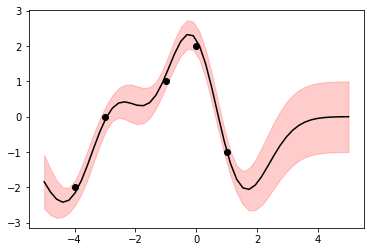

In [10]:
a = post_cov.diagonal().reshape(-1,1)
a = np.sqrt(a)
plt.figure()
plt.plot(x_data,y_data,'o',color='k')
plt.plot(x.reshape(-1),post_mean,color='k')
plt.fill_between(x.reshape(-1), (post_mean-a).reshape(-1),(post_mean+a).reshape(-1),alpha=0.2,color='r')
plt.show()

## 2. Predictive Covariance Function

Given $var(f(\mathbf{x_*})) = \phi(x_*)^TA^{-1}\phi(x_*)$ show $cov(f(\mathbf{x_*}),f(\mathbf{x_*'})) = \phi(x_*)^TA^{-1}\phi(x_*')$.

Covariance Matrix of $x_*$ and $x_*'$ is just selecting element on varaince matrix. 

Asumme $x_* = x_{*_1} \cup x_{*_2}$. And define indication matrix $x_{*_1} = I_1x_{*} $, $x_{*_2} = I_2x_{*} $ 

$cov(f(\mathbf{x_{*_1}}),f(\mathbf{x_{*_2}})) = I_1^T\phi(x_{*})^TA^{-1}\phi(x_{*}) I_2$ 

As a result

$cov(f(\mathbf{x_{*_1}}),f(\mathbf{x_{*_2}})) = \phi(x_{*_1})^TA^{-1}\phi(x_{*_2})$

## 3. Brownian Bridge

Winner Process $W(t) - W(s) \sim \mathcal{N}(0,t-s)$ \
Brownian Bridge $X(t) = W(t) - tW(1)$ \
$m(X(t)) = 0$ \
$\kappa(t,s)  = \mathbb{E}[X(t)X(s)] = \mathbb{E}[[W(t) - tW(1)][W(s)-sW(1)]]$\
$ =\mathbb{E}[W(t)W(s)]-ts = min(t,s) - ts$ since W(1)=1

In [14]:
def b_cov(x1,x2):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] = min(xq,xp)-xq*xp
    return out

In [15]:
x = np.linspace(0,1,50)
mean = np.zeros_like(x)
cov = b_cov(x,x)

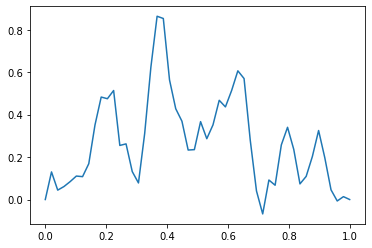

In [16]:
x_sample = np.random.multivariate_normal(mean,cov)
plt.plot(x,x_sample)
plt.show()

## 4. Predictive Variance Decreases with Increase of data

Show $var_n(f(\mathbf{x}_*) - var_{n-1}(f(\mathbf{x}_*) \le 0$ \
$var_n(f(\mathbf{x}_*) = k(\mathbf{x}_*,\mathbf{x}_*) - \mathbf{k}_*^T(K+\sigma_n^2I)^{-1}\mathbf{k}_*$

Then $var_{n-1}(f(\mathbf{x}_*) - var_n(f(\mathbf{x}_*) = \mathbf{k_n}_*^T(K_n+\sigma_n^2I)^{-1}\mathbf{k_n}_* - \mathbf{k_{n-1}}_*^T(K_{n-1}+\sigma_n^2I)^{-1}\mathbf{k_{n-1}}_*$ - Eq(1)

And show it is positive semidefinite.

We can decompose $\mathbf{k_{n_*}} = \begin{bmatrix} \mathbf{k_{{n-1}_*}} \\ g \end{bmatrix}$ and $\mathbf{k_n}_*^T(K_n+\sigma_n^2I)^{-1}\mathbf{k_n}_* = \begin{bmatrix} \mathbf{k_{n-1}}_*^T(K_{n-1}+\sigma_n^2I)^{-1}\mathbf{k_{n-1}}_* & C \\ B & D \end{bmatrix} $

Then we got Eq(1) as 

$ \begin{bmatrix} \mathbf{k_{{n-1}_*}} \\ g \end{bmatrix}^T \begin{bmatrix} \mathbf{k_{n-1}}_*^T(K_{n-1}+\sigma_n^2I)^{-1}\mathbf{k_{n-1}}_* & C \\ B & D \end{bmatrix} \begin{bmatrix} \mathbf{k_{{n-1}_*}} \\ g \end{bmatrix}$

$= g^TB\mathbf{k_{n-1}}_* + \mathbf{k_{n-1}}_*^TCg + g^TDg$ - Eq(2)

Since all of the elements in g,B,C,D is non-negative, Eq (2) becomes positive semidefinite.